In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.stats
import h5py
import os

from cca.kron_pca import form_lag_matrix, toeplitzify
from cca.cov_util import calc_cross_cov_mats_from_cov
from cca.synth_data import gen_lorenz_system
from cca import ComplexityComponentsAnalysis

RESULTS_FILENAME = "lorenz_results_mediansubspace.hdf5"

In [4]:
def gen_noise_cov(N, D, var, V_noise=None):
    noise_spectrum = var*np.exp(-2*np.arange(N)/D)
    if V_noise is None:
        V_noise = scipy.stats.ortho_group.rvs(N)
    noise_cov = np.dot(V_noise, np.dot(np.diag(noise_spectrum), V_noise.T))
    return noise_cov

def random_basis(N, D):
    return scipy.stats.ortho_group.rvs(N)[:, :D]

def median_subspace(N, D, num_samples=5000, V_0=None):
    subspaces = np.zeros((num_samples, N, D))
    angles = np.zeros((num_samples, min(D, V_0.shape[1])))
    if V_0 is None:
        V_0 = np.eye(N)[:, :D]
    for i in range(num_samples):
        subspaces[i] = random_basis(N, D)
        angles[i] = np.rad2deg(scipy.linalg.subspace_angles(V_0, subspaces[i]))
    median_angles = np.median(angles, axis=0)
    median_subspace_idx = np.argmin( np.sum((angles-median_angles)**2, axis=1) )
    median_subspace = subspaces[median_subspace_idx]
    return median_subspace

def plot_3d(X, color="black", linewidth=2, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    ax.plot(X[:, 0], X[:, 1], X[:, 2], c=color, linewidth=linewidth)

In [372]:
#Set this to False for safety
delete_old_file = False

#Set parameters
T = 10
N = 30
noise_dim = 7
snr_vals = np.logspace(-2, 2, 20)

#Save params
if delete_old_file:
    try:
        os.remove(RESULTS_FILENAME)
    except OSError:
        pass
f = h5py.File(RESULTS_FILENAME, "w-")
f.attrs["T"] = T
f.attrs["N"] = N
f.attrs["noise_dim"] = noise_dim
f.attrs["snr_vals"] = snr_vals

#Generate Lorenz dynamics
num_samples = 10000
integration_dt = 0.005
data_dt = 0.025
X_dynamics = gen_lorenz_system((num_samples + 1000)*data_dt, integration_dt, data_dt)[1000:]
X_dynamics = (X_dynamics - X_dynamics.mean(axis=0))/X_dynamics.std(axis=0)
dynamics_var = np.max(scipy.linalg.eigvalsh(np.cov(X_dynamics.T)))

#Save dynamics
f.create_dataset("X_dynamics", data=X_dynamics)
f.attrs["dynamics_var"] = dynamics_var

#Generate dynamics embedding matrix (will remain fixed)
np.random.seed(42)
V_dynamics = random_basis(N, 3)
X = np.dot(X_dynamics, V_dynamics.T)

#Generate a subspace with median principal angles w.r.t. dynamics subspace
V_noise = median_subspace(N, noise_dim, num_samples=50000, V_0=V_dynamics)

#Extend V_noise to a basis for R^N
V_noise_comp = scipy.linalg.orth(np.eye(N) - np.dot(V_noise, V_noise.T))
V_noise = np.concatenate((V_noise, V_noise_comp), axis=1)

#Save embeded dynamics and embedding matrices
f.create_dataset("X", data=X)
f.attrs["V_dynamics"] = V_dynamics
f.attrs["V_noise"] = V_noise

#To-save: noisy data, reconstructed PCA, reconstructed DCA
X_noisy_dset = f.create_dataset("X_noisy", (len(snr_vals), num_samples, N))
X_pca_trans_dset = f.create_dataset("X_pca_trans", (len(snr_vals), num_samples, 3))
X_dca_trans_dset = f.create_dataset("X_dca_trans", (len(snr_vals), num_samples, 3))

#Loop over SNR vals
for snr_idx in range(len(snr_vals)):
    snr = snr_vals[snr_idx]
    print("snr =", snr)
    noise_var = dynamics_var/snr
    
    #Generate noise covariacne
    noise_cov = gen_noise_cov(N, noise_dim, noise_var, V_noise=V_noise)
    
    #Generate noisy data
    X_noisy = X + np.random.multivariate_normal(mean=np.zeros(N), cov=noise_cov, size=num_samples)
    X_noisy = X_noisy - X_noisy.mean(axis=0)

    #Save noisy data
    X_noisy_dset[snr_idx] = X_noisy

    #Compute PSD+Toeplitz spatiotemporal covariance
    X_lags = form_lag_matrix(X_noisy, T)
    cov = np.dot(X_lags.T, X_lags)/len(X_lags)
    cov_toep = toeplitzify(cov, N, T)
    min_eig = np.min(np.linalg.eigvalsh(cov_toep))
    if min_eig < 0:
        cov_toep += (-min_eig + 1e-4)*np.eye(cov_toep.shape[0])
    cross_cov_mats = calc_cross_cov_mats_from_cov(N, T, cov_toep)

    #Run DCA
    opt = ComplexityComponentsAnalysis(init="random_ortho")
    opt.cross_covs = cross_cov_mats
    opt.fit_projection(d=3, n_init=5)
    V_dca = opt.coef_

    #Run PCA
    V_pca = scipy.linalg.eigh(np.cov(X_noisy.T))[1][:, ::-1][:, :3]

    #Project data onto DCA and PCA bases
    X_dca = np.dot(X_noisy, V_dca)
    X_pca = np.dot(X_noisy, V_pca)

    #Linearly trasnform projected data to be close to original Lorenz attractor
    beta_pca = np.linalg.lstsq(X_pca, X_dynamics, rcond=None)[0]
    beta_dca = np.linalg.lstsq(X_dca, X_dynamics, rcond=None)[0]
    X_pca_trans = np.dot(X_pca, beta_pca)
    X_dca_trans = np.dot(X_dca, beta_dca)

    #Save transformed projections
    X_pca_trans_dset[snr_idx] = X_pca_trans
    X_dca_trans_dset[snr_idx] = X_dca_trans

snr = 0.01
snr = 0.016237767391887217
snr = 0.026366508987303583
snr = 0.04281332398719394
snr = 0.06951927961775606
snr = 0.11288378916846889
snr = 0.18329807108324356
snr = 0.29763514416313175
snr = 0.4832930238571752
snr = 0.7847599703514611
snr = 1.2742749857031335
snr = 2.06913808111479
snr = 3.359818286283781
snr = 5.455594781168514
snr = 8.858667904100823
snr = 14.38449888287663
snr = 23.357214690901213
snr = 37.92690190732246
snr = 61.584821106602604
snr = 100.0


In [6]:
def lorenz_fig_axes(fig_width=12, fig_height=4, wpad_edge=0.05, wpad_mid=0.05, hpad_edge=0.05, hpad_mid=0.05):
    sq_width = (1 - 2*wpad_edge - 3*wpad_mid)/4
    sq_height = sq_width * fig_width/fig_height
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    #Add top row
    #4 squares
    top_row_y = hpad_edge + sq_height + hpad_mid
    
    #First one (Lorenz attractor plot) should be squished vertically
    smush_amt = 0.2*sq_height
    ax1 = fig.add_axes((wpad_edge, top_row_y + smush_amt, sq_width, sq_height - 2*smush_amt), projection='3d')
    
    ax2 = fig.add_axes((wpad_edge + sq_width + wpad_mid, top_row_y, sq_width, sq_height))
    ax3 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, top_row_y, sq_width, sq_height))
    
    #Last square in top row has 2 pannels 
    upper_right_pad_top = 0.1*sq_height
    upper_right_pad_bottom = 0.1*sq_height
    upper_right_hpad = 0.2*sq_height
    upper_right_ax_height = (sq_height - upper_right_hpad - upper_right_pad_top - upper_right_pad_bottom)/2
    ax5 = fig.add_axes((wpad_edge + 3*sq_width + 3*wpad_mid,
                        top_row_y + upper_right_pad_bottom,
                        sq_width, upper_right_ax_height))
    ax4 = fig.add_axes((wpad_edge + 3*sq_width + 3*wpad_mid,
                        top_row_y + upper_right_pad_bottom + upper_right_ax_height + upper_right_hpad,
                        sq_width, upper_right_ax_height))
        
    #Bottom row
    #Special Lorenz plots on the left
    #First, do boring square on upper right
    ax12 = fig.add_axes((wpad_edge + 3*sq_width + 3*wpad_mid, hpad_edge, sq_width, sq_height))
    
    #Then, add a box with 6 subplots for Lorenz displays
    lorenz_box_width = (1 - 2*wpad_edge - wpad_mid - sq_width)
    lorenz_box_height = sq_height
    
    lorenz_pad_left = 0.15*lorenz_box_width
    lorenz_pad_right = 0.0*lorenz_box_width
    lorenz_wspace = 0.05*lorenz_box_width
    
    lorenz_pad_top = 0.15*lorenz_box_height
    lorenz_pad_bottom = 0.0*lorenz_box_height
    lorenz_hspace = 0.05*lorenz_box_height
    
    lorenz_ax_width = (lorenz_box_width - lorenz_pad_left - lorenz_pad_right - 2*lorenz_wspace)/3
    lorenz_ax_height = (lorenz_box_height - lorenz_pad_bottom - lorenz_pad_top - lorenz_hspace)/2
    
    ax7 = fig.add_axes((wpad_edge + lorenz_pad_left,
                        hpad_edge + lorenz_pad_bottom,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    ax6 = fig.add_axes((wpad_edge + lorenz_pad_left,
                        hpad_edge + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    
    ax9 = fig.add_axes((wpad_edge + lorenz_pad_left + lorenz_wspace + lorenz_ax_width,
                        hpad_edge + lorenz_pad_bottom,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    ax8 = fig.add_axes((wpad_edge + lorenz_pad_left + lorenz_wspace + lorenz_ax_width,
                        hpad_edge + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace,
                        lorenz_ax_width, lorenz_ax_height), projection='3d')
    
    ax11 = fig.add_axes((wpad_edge + lorenz_pad_left + 2*lorenz_wspace + 2*lorenz_ax_width,
                         hpad_edge + lorenz_pad_bottom,
                         lorenz_ax_width, lorenz_ax_height), projection='3d')
    ax10 = fig.add_axes((wpad_edge + lorenz_pad_left + 2*lorenz_wspace + 2*lorenz_ax_width,
                         hpad_edge + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace,
                         lorenz_ax_width, lorenz_ax_height), projection='3d')
    
    dca_txt_x = wpad_edge + lorenz_pad_left/2
    dca_txt_y = hpad_edge + lorenz_pad_bottom + lorenz_ax_height + lorenz_hspace + lorenz_ax_height/2
    pca_txt_x = dca_txt_x
    pca_txt_y = hpad_edge + lorenz_pad_bottom + lorenz_ax_height/2
    
    
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
    txt_cords = [(dca_txt_x, dca_txt_y), (pca_txt_x, pca_txt_y)]
    
    return axes, txt_cords



In [9]:
f = h5py.File(RESULTS_FILENAME, "r")
snr_vals = f.attrs["snr_vals"]
X = f["X"]
X_noisy_dset = f["X_noisy"]
X_pca_trans_dset = f["X_pca_trans"]
X_dca_trans_dset = f["X_dca_trans"]
X_dynamics = f["X_dynamics"]

r2_vals = np.zeros((len(snr_vals), 2))
for snr_idx in range(len(snr_vals)):
    X_pca_trans = X_pca_trans_dset[snr_idx]
    X_dca_trans = X_dca_trans_dset[snr_idx]
    r2_pca = 1 - np.sum((X_pca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
    r2_dca = 1 - np.sum((X_dca_trans - X_dynamics)**2)/np.sum((X_dynamics - np.mean(X_dynamics, axis=0))**2)
    r2_vals[snr_idx] = [r2_pca, r2_dca]

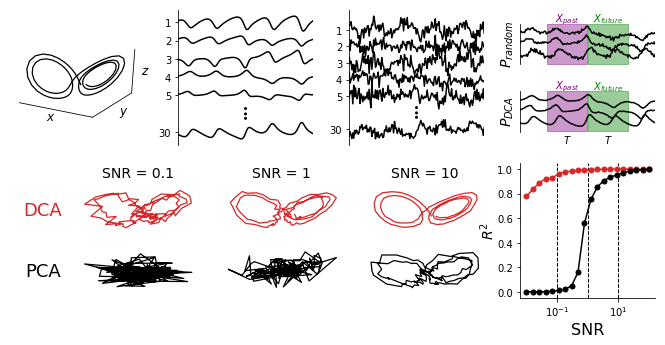

In [11]:
#Create axes
axes, txt_cords = lorenz_fig_axes(fig_width=10, fig_height=5)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#ax1: Lorenz 3D Plot
ax1_label_fontsize=12
ax1_T_to_show = 150

plot_3d(X_dynamics[:ax1_T_to_show], ax=ax1, linewidth=1.25)
#ax1.grid(b=None)
ax1.xaxis.set_pane_color((1,1,1,0))
ax1.yaxis.set_pane_color((1,1,1,0))
ax1.zaxis.set_pane_color((1,1,1,0))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel("$x$", labelpad=-15, fontsize=ax1_label_fontsize)
ax1.set_ylabel("$y$", labelpad=-13, fontsize=ax1_label_fontsize)
ax1.set_zlabel("$z$", labelpad=-15, fontsize=ax1_label_fontsize)
ax1.dist = 9

#ax2 and ax3: Plots of noiseless and noisy embeddings
T_to_show = 150
X_display_idx = 11 #index of noisy X dataset to show (make sure to change if SNR spacing changes)
N_to_show = 5 #number of channels to plot (also plot last one)
y_spacing = 1.5 #spacing between adjacent traces on the y-axis (in data units)
y_jump = 3 #empty y-space for elipsis

#plot traces
max_y = y_spacing*(N_to_show - 1) + y_jump
offset_vals = [max_y - y_spacing*i for i in range(N_to_show)] + [0]
t = np.arange(T_to_show)*0.025
for i in range(N_to_show):
    ax2.plot(t, X[:len(t), i] + offset_vals[i], c="black")
    ax3.plot(t, X_noisy_dset[X_display_idx, :len(t), i] + offset_vals[i], c="black")
ax2.plot(t, X[:len(t), N_to_show], c="black")
ax3.plot(t, X_noisy_dset[X_display_idx, :len(t), N_to_show], c="black")

#configure the axes
for ax in [ax2, ax3]:
    ax.set_xlim(np.min(t), np.max(t))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks(offset_vals)
    ax.set_yticklabels(list(np.arange(N_to_show)+1) + [X.shape[1]])
    ax.text(np.mean(t), y_jump*0.6,
            "···", rotation=90, fontsize=16, color="black",
            horizontalalignment="center", verticalalignment="center",
            fontweight="heavy", fontname="Georgia")

#ax4 and ax5: Plots of projections (DCA and random)

#get a random projection of X_noisy and transorm for Lorenz comparison
to_proj = X_noisy_dset[X_display_idx]
np.random.seed(42)
X_random = np.dot(to_proj, scipy.stats.ortho_group.rvs(to_proj.shape[1])[:, :3])
beta_random = np.linalg.lstsq(X_random, X_dynamics, rcond=None)[0]
X_random_trans = np.dot(X_random, beta_random)

#plot traces
ax4_y_spacing = 3
ax4_max_y = 2*ax4_y_spacing
ax4_offset_vals = [ax4_max_y - i*ax4_y_spacing for i in range(3)]
for i in range(3):
    ax4.plot(t, X_random_trans[:len(t), i] + ax4_offset_vals[i], c="black")
    ax5.plot(t, X_dca_trans_dset[X_display_idx, :len(t), i] + ax4_offset_vals[i], c="black")
    
#configure axes
for ax in [ax4, ax5]:
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlim(np.min(t), np.max(t))
    ax.set_ylim(-ax4_y_spacing*1.025, ax4_max_y+ax4_y_spacing*1.025)
    
#plot the colored past/future boxes
t_range = t[-1] - t[0]
t_mid = np.mean(t)
t_low = t_mid - t_range*0.3
t_high = t_mid + t_range*0.3
n_t = 100
t_low_vals = np.linspace(t_low, t_mid, n_t)
t_high_vals = np.linspace(t_mid, t_high, n_t)
y_low = -1*ax4_y_spacing
y_high = ax4_max_y + ax4_y_spacing
for ax in [ax4, ax5]:
    ax.fill_between(t_low_vals[:-1], y_low, y_high, alpha=0.4, color="purple")
    ax.fill_between(t_high_vals[1:], y_low, y_high, alpha=0.4, color="green")
    ax.text((t_low+t_mid)/2, y_high*1.4, "$X_{past}$", color="purple",
            horizontalalignment='center', verticalalignment='top')
    ax.text((t_mid+t_high)/2, y_high*1.4, "$X_{future}$",  color="green",
            horizontalalignment='center', verticalalignment='top')

#Add T labels
ax5.text((t_low+t_mid)/2, -ax4_y_spacing*1.2, "$T$", color="black",
        horizontalalignment='center', verticalalignment='top')
ax5.text((t_mid+t_high)/2, -ax4_y_spacing*1.2, "$T$", color="black",
        horizontalalignment='center', verticalalignment='top')

ax4.set_ylabel("$P_{random}$", fontsize=14)
ax5.set_ylabel("$P_{DCA}$", fontsize=14)

#Plot Lorenz panels

dca_axes = [ax6, ax8, ax10]
pca_axes = [ax7, ax9, ax11]

dca_color = default_colors[3]
pca_color = "black"
plt_snr_vals = [0.1, 1.0, 10.0]
plt_snr_strs = ["0.1", "1", "10"]
plt_idx = [np.argmin((snr_vals-snr)**2) for snr in plt_snr_vals]

for i in range(3):
    plot_3d(X_dca_trans_dset[plt_idx[i], :T_to_show], ax=dca_axes[i], color=dca_color, linewidth=1.25)
    plot_3d(X_pca_trans_dset[plt_idx[i], :T_to_show], ax=pca_axes[i], color=pca_color, linewidth=1.25)
    dca_axes[i].set_title("SNR = " + plt_snr_strs[i], pad=10, fontsize=14)
    
for ax in dca_axes + pca_axes:
    ax.set_axis_off()
    ax.dist = 7.5
    
plt.gcf().text(txt_cords[0][0], txt_cords[0][1], "DCA", va="center", ha="center", fontsize=18, color=dca_color)
plt.gcf().text(txt_cords[1][0], txt_cords[1][1], "PCA", va="center", ha="center", fontsize=18, color=pca_color)

#Finally, the R2 vs SNR plot
ax12.plot(snr_vals, r2_vals[:, 1], label="DCA", linewidth=1.5, marker=".", markersize=10, c=dca_color, zorder=10)
ax12.plot(snr_vals, r2_vals[:, 0], label="PCA", linewidth=1.5, marker=".", markersize=10, c=pca_color, zorder=11)
ax12.set_xscale("log")
for snr in plt_snr_vals:
    ax12.axvline(snr, c="black", linestyle='--', linewidth=1, zorder=0)

ax12.set_xlabel("SNR", fontsize=16)
ax12.set_ylabel("$R^2$", fontsize=14, labelpad=0)
ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
#ax12.legend(frameon=True)
ax12.set_zorder(10**5)

plt.savefig("lorenz_fig.pdf", bbox_inches="tight")

